In [6]:
import imapclient
import pandas as pd
import getpass

youremail = input()
yourpassword = getpass.getpass()


cdhimmel@gmail.com
········


In [11]:
imapObj = imapclient.IMAPClient("imap.googlemail.com", ssl=True,port=993)
imapObj.login(youremail, yourpassword)
imapObj.select_folder("INBOX", readonly=True)

UIDs = imapObj.search('(SINCE "01-Jan-2016")')


In [12]:
mails = []
for msgid, data in imapObj.fetch(UIDs, ["ENVELOPE"]).items():
    envelope = data[b"ENVELOPE"]
    date = envelope.date
    if envelope.subject is not None:
        subject = envelope.subject.decode()
    else:
        subject = None
    mails.append((subject, date))

mail_df = pd.DataFrame(mails)
mail_df.columns = ["Subject", "Date"]
mail_df["Date"] = pd.to_datetime(mail_df["Date"])
mail_df = mail_df.set_index("Date")

print("A total of {} e-mails loaded.".format(len(mail_df)))


A total of 76837 e-mails loaded.


In [13]:
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

weekdays = [calendar.day_name[i] for i in range(7)]

# E-Mails per Hour
per_hour = pd.DataFrame(mail_df["Subject"].resample("h").count())
per_hour_day = (
    per_hour.groupby([per_hour.index.hour]).sum()
    / per_hour.groupby([per_hour.index.hour]).count()
)
per_hour_day.reset_index(inplace=True)
per_hour_day.columns = ["Hour", "Count"]

In [14]:
# E-Mails per day
per_day = pd.DataFrame(mail_df["Subject"].resample("d").count())
per_day_week = (
    per_day.groupby([per_day.index.weekday]).sum()
    / per_day.groupby([per_day.index.weekday]).count()
)
per_day_week.reset_index(inplace=True)
per_day_week.columns = ["Weekday", "Count"]
per_day_week["Weekday"] = weekdays

Text(0.5, 1.0, 'Emails per hour')

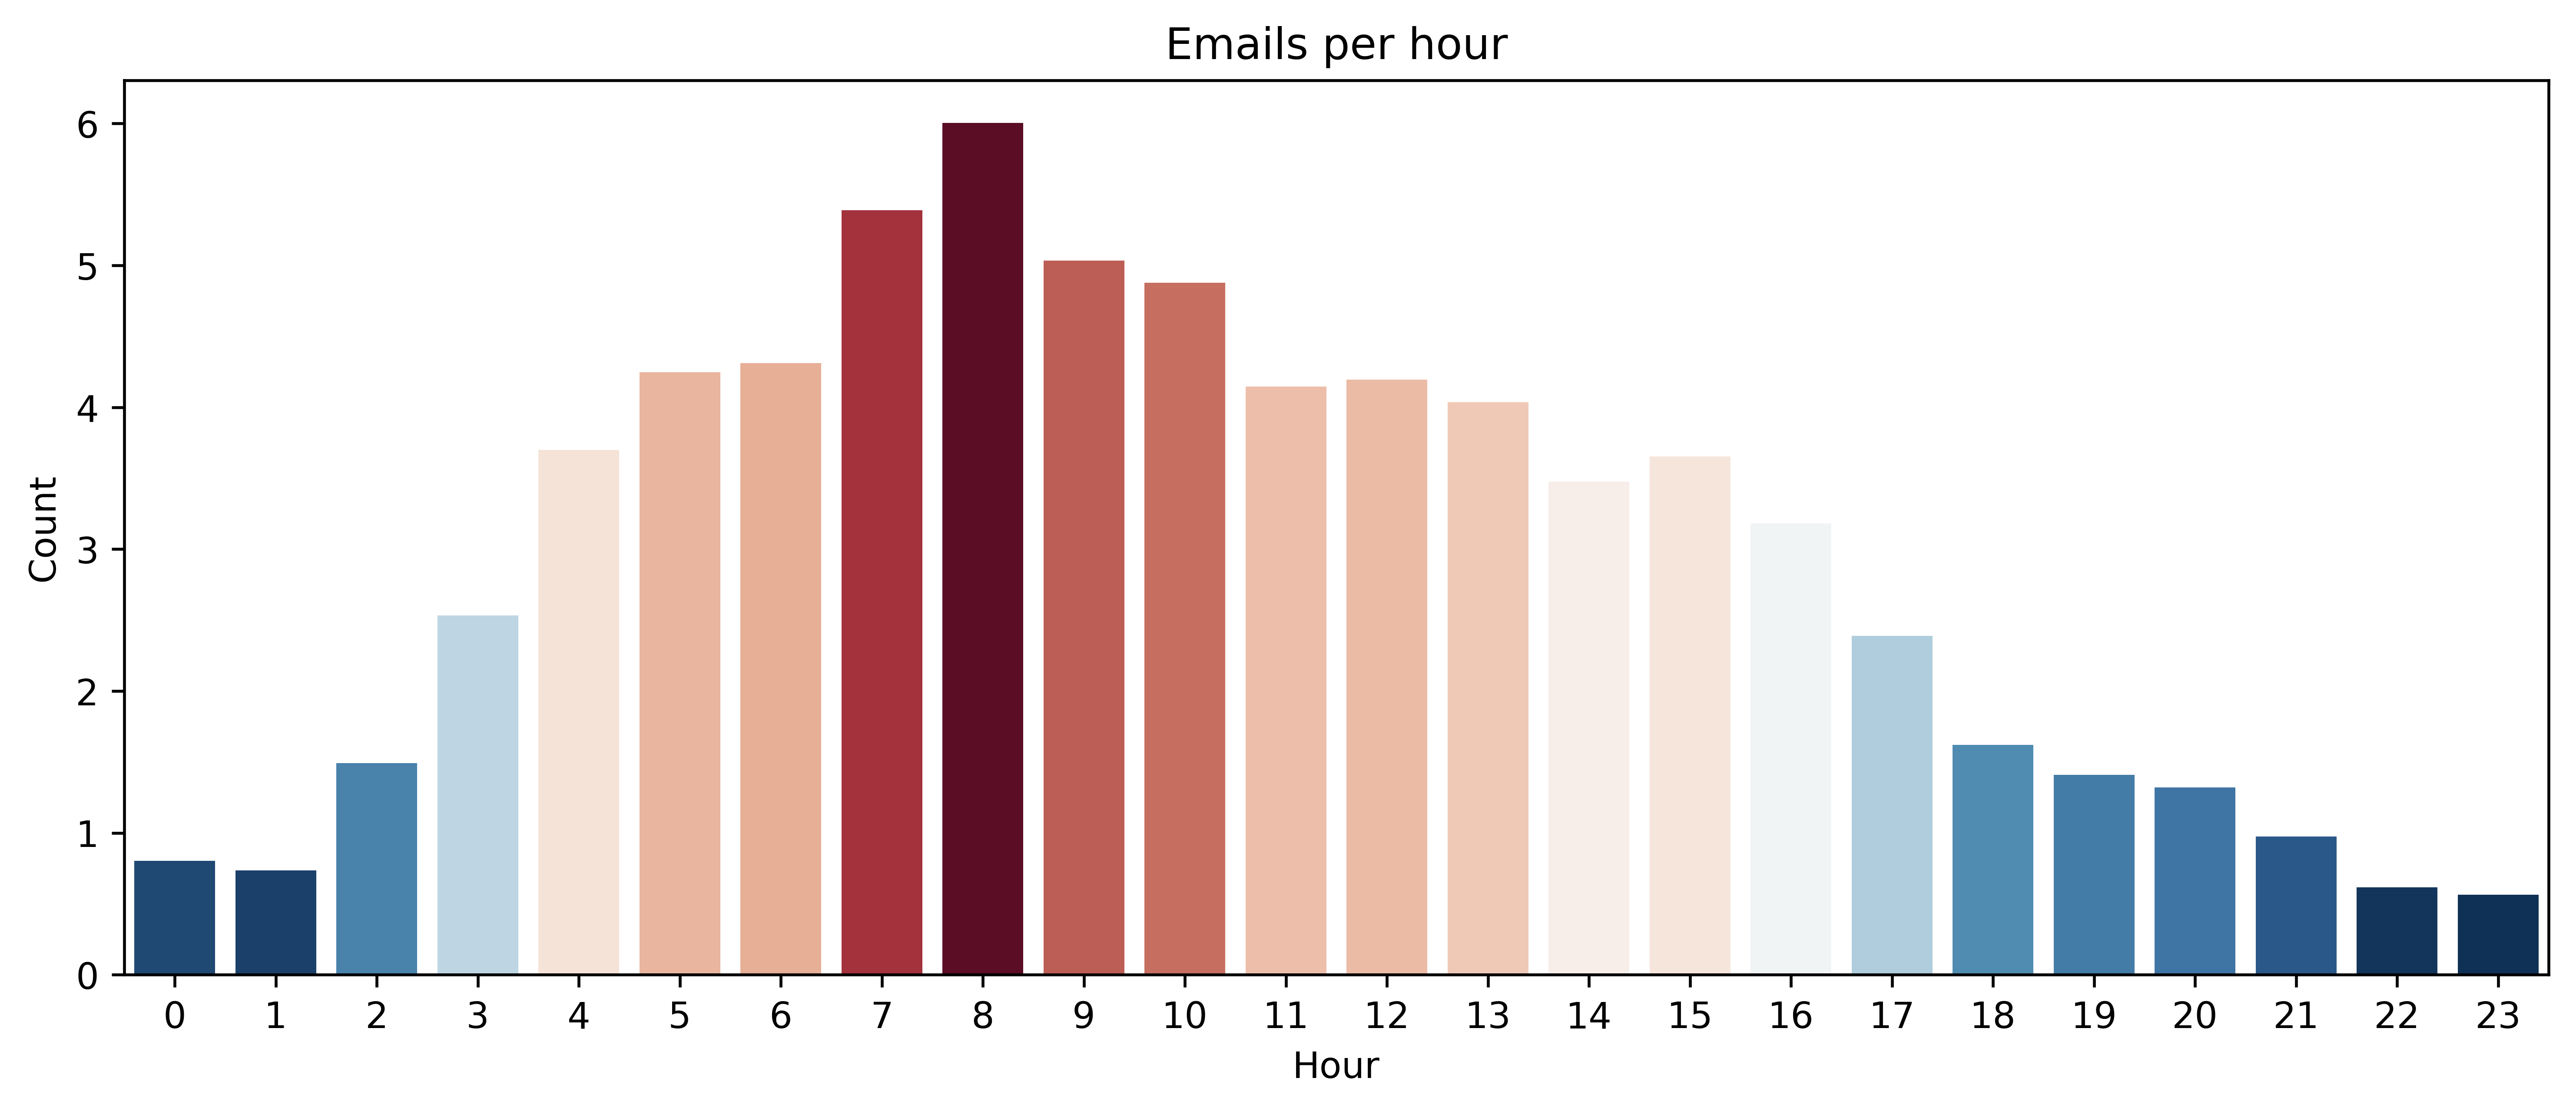

In [15]:
def return_cmap(data):
    # Function to create a colormap
    v = data["Count"].values
    colors = plt.cm.RdBu_r((v - v.min()) / (v.max() - v.min()))
    return colors

plt.figure(figsize=(12, 10), dpi=600)
plt.subplot(2, 1, 1)
cmap = return_cmap(per_hour_day)
sns.barplot(x="Hour", y="Count", data=per_hour_day, palette=cmap)
plt.title("Emails per hour")

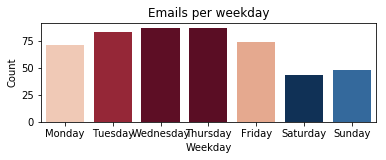

Average number of emails per day: 70.71


In [16]:
plt.subplot(2, 1, 2)
cmap = return_cmap(per_day_week)
sns.barplot(x="Weekday", y="Count", data=per_day_week, palette=cmap)
plt.title("Emails per weekday")

plt.show()

print(
    "Average number of emails per day: {:.2f}".format(
        per_hour_day.sum()["Count"]
    )
)

In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

data = per_day.copy()
test_split = int(len(data) * 0.8)

pred_base = []
for i in range(len(data) - test_split):
    train_data = data[i : test_split + i]
    test_data = data.iloc[test_split + i]
    train_data_week = (
        train_data.groupby([train_data.index.weekday]).sum()
        / train_data.groupby([train_data.index.weekday]).count()
    )
    baseline_prediction = train_data_week.loc[test_data.name.weekday()]
    pred_base.append(baseline_prediction.values)

test_data = data[test_split:]

mse_baseline = mean_squared_error(test_data.values, pred_base)

print("RMSE for BASELINE {:.2f}".format(np.sqrt(mse_baseline)))

RMSE for BASELINE 13.00


C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Train on 867 samples, validate on 210 samples
Epoch 1/30
 - 5s - loss: 0.0188 - val_loss: 0.0217
Epoch 2/30
 - 4s - loss: 0.0117 - val_loss: 0.0262
Epoch 3/30
 - 4s - loss: 0.0112 - val_loss: 0.0270
Epoch 4/30
 - 4s - loss: 0.0097 - val_loss: 0.0240
Epoch 5/30
 - 4s - loss: 0.0099 - val_loss: 0.0233
Epoch 6/30
 - 4s - loss: 0.0097 - val_loss: 0.0154
Epoch 7/30
 - 4s - loss: 0.0092 - val_loss: 0.0150
Epoch 8/30
 - 4s - loss: 0.0091 - val_loss: 0.0145
Epoch 9/30
 - 4s - loss: 0.0089 - val_loss: 0.0164
Epoch 10/30
 - 4s - loss: 0.0086 - val_loss: 0.0135
Epoch 11/30
 - 4s - loss: 0.0085 - val_loss: 0.0127
Epoch 12/30
 - 4s - loss: 0.0082 - val_loss: 0.0127
Epoch 13/30
 - 4s - loss: 0.0085 - val_loss: 0.0125
Epoch 14/30
 - 4s - loss: 0.0081 - val_loss: 0.0121
Epoch 15/30
 - 4s - loss: 0.0083 - val_loss: 0.0120
Epoch 16/30
 - 4s - loss: 0.0081 - val_loss: 0.0119
Epoch 17/30
 - 4s - loss: 0.0083 - val_loss: 0.0110
Epoch 18/30
 - 4s - loss: 0.0081 - val_loss: 0.0115
Epoch 19/30
 - 4s - loss: 0

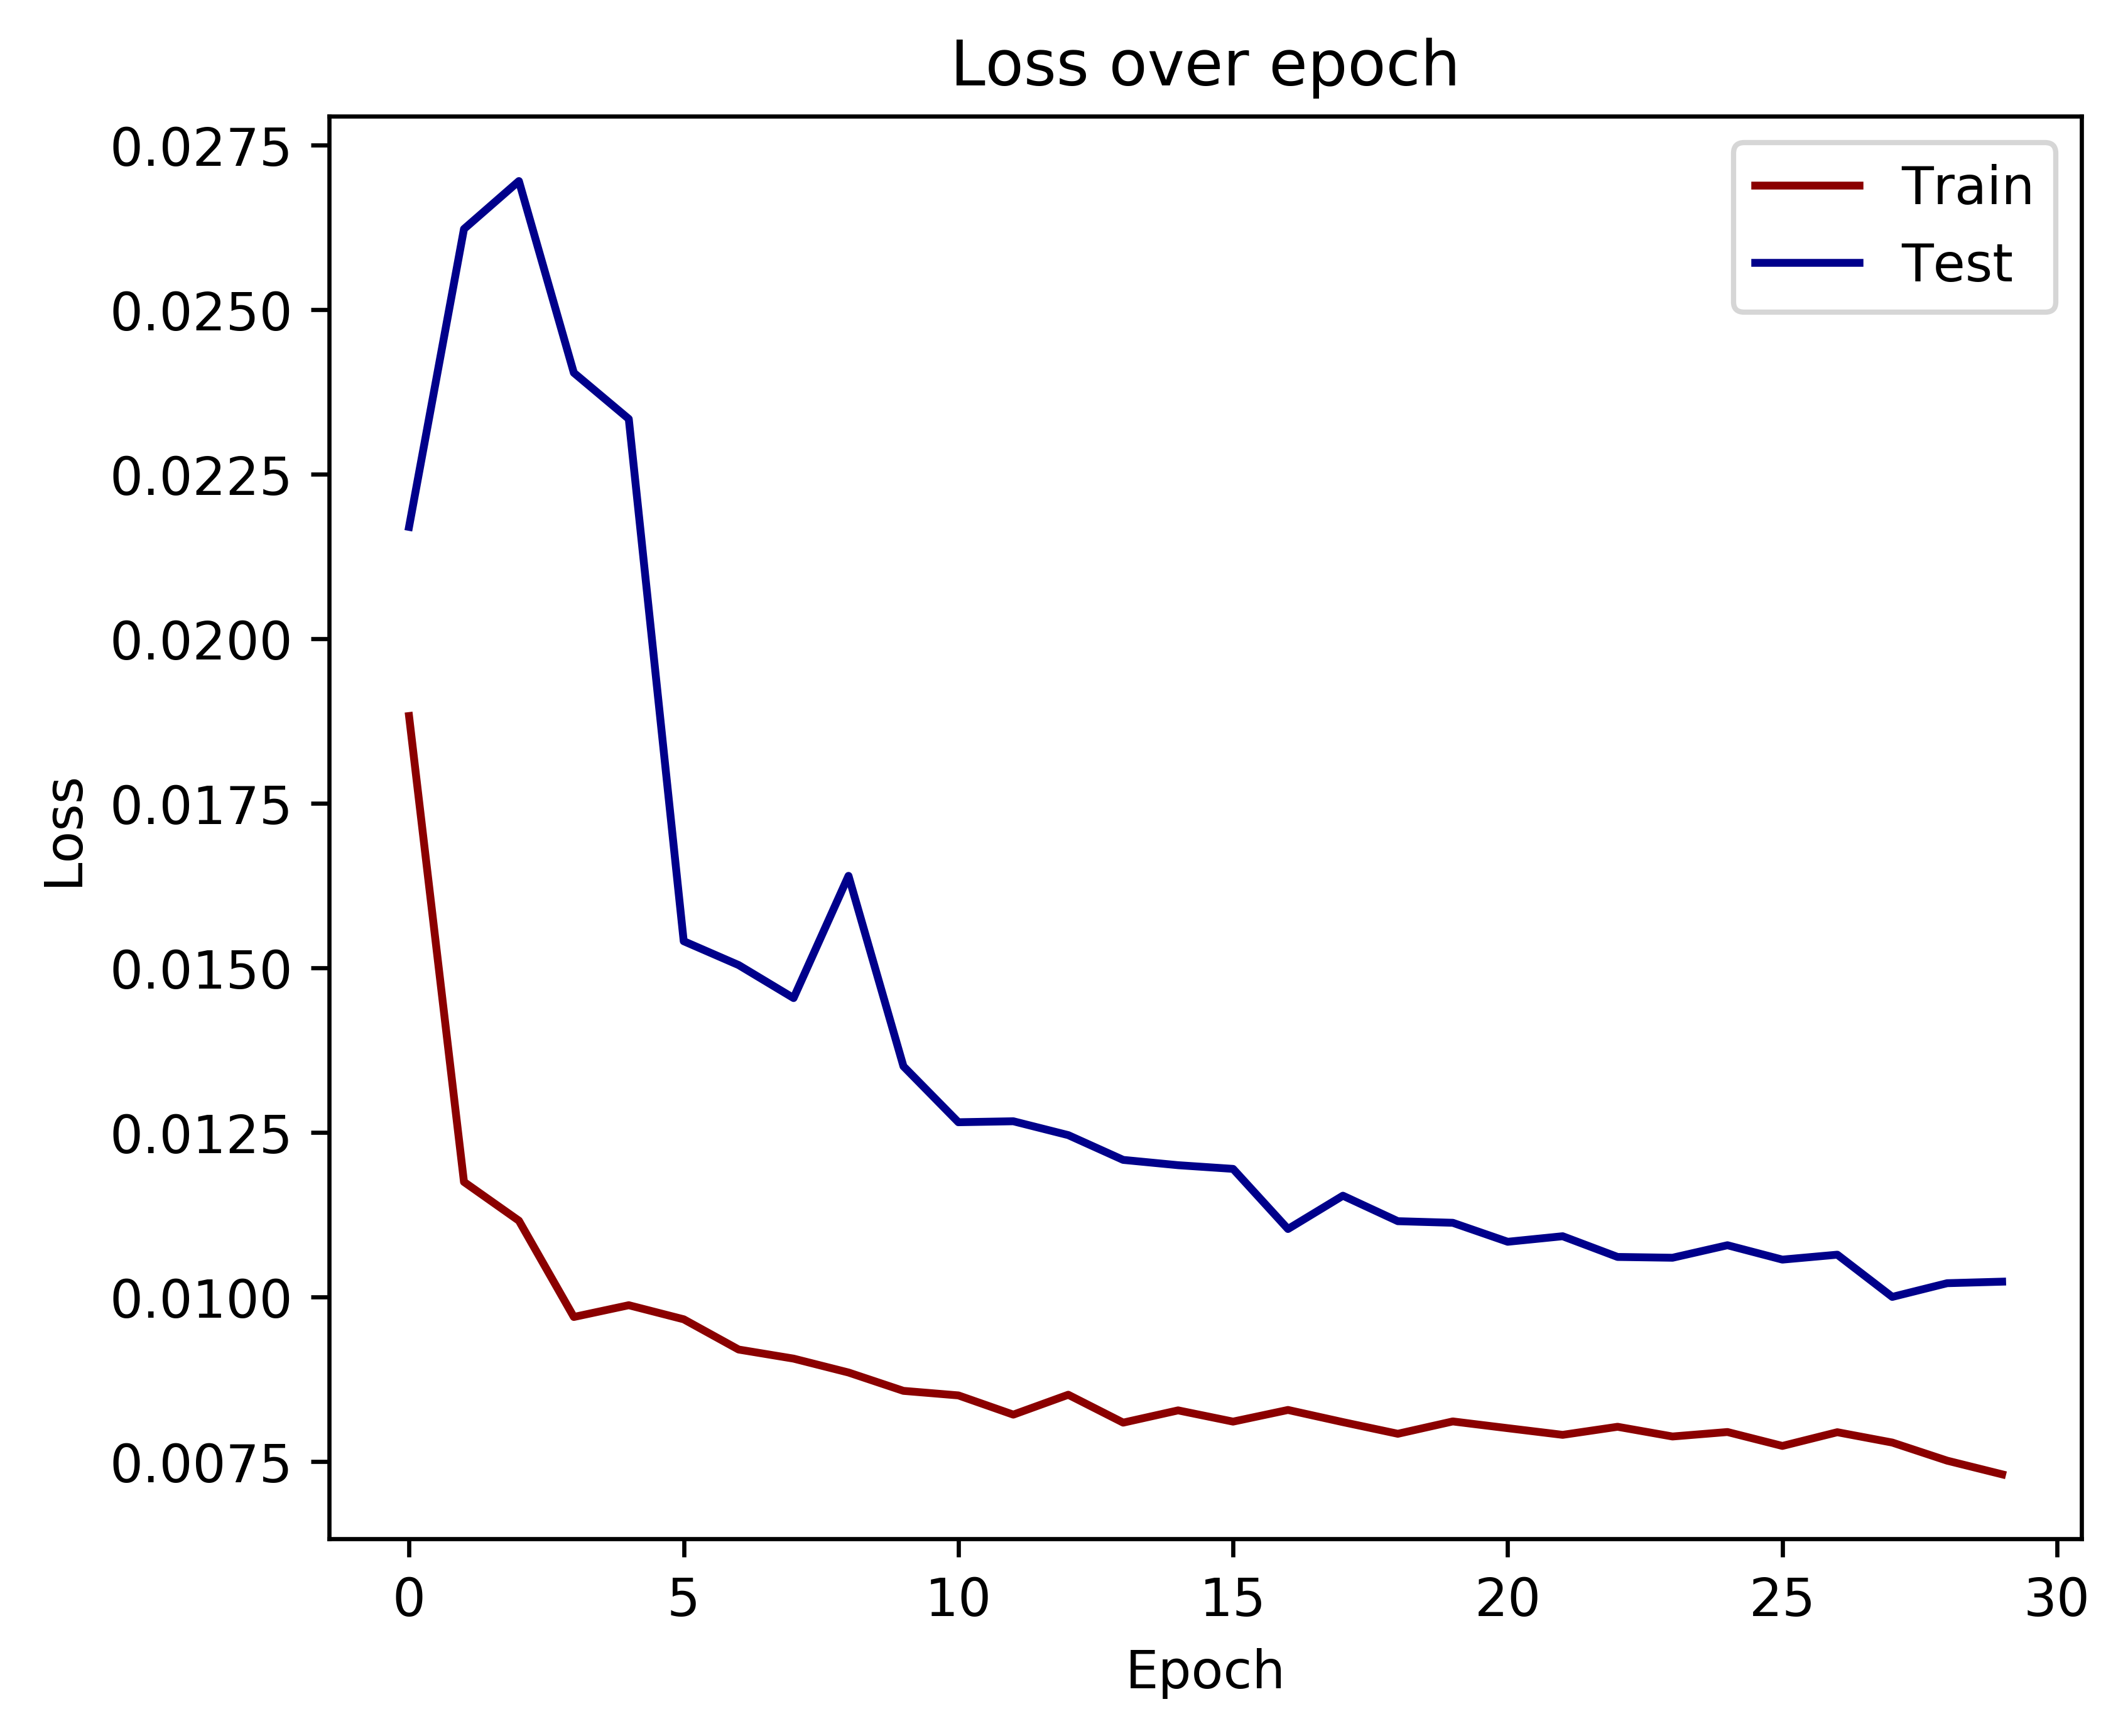

RMSE for LSTM 12.54


In [19]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

def get_window_data(data, window):
    # Get window data and scale
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data.reshape(-1, 1))

    X = []
    y = []

    for i in range(len(data) - window - 1):
        X.append(data[i : i + window])
        y.append(data[i + window + 1])

    X = np.asarray(X)
    y = np.asarray(y)
    return X, y, scaler


window_size = 6
X, y, scaler = get_window_data(per_day["Subject"].values, window_size)

X_train = X[:test_split]
X_test = X[test_split:]

y_train = y[:test_split]
y_test = y[test_split:]

model = Sequential()
model.add(LSTM(50, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")


history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=1,
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False,
)

# plot history

plt.figure(figsize=(6, 5), dpi=600)
plt.plot(history.history["loss"], 'darkred', label="Train")
plt.plot(history.history["val_loss"], 'darkblue', label="Test")
plt.title("Loss over epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

mse_lstm = mean_squared_error(
    scaler.inverse_transform(y_test),
    scaler.inverse_transform(model.predict(X_test)),
)
print("RMSE for LSTM {:.2f}".format(np.sqrt(mse_lstm)))

In [23]:
from fbprophet import Prophet
from tqdm import tqdm

prophet_data = data.reset_index()
prophet_data["ds"] = prophet_data["Date"]
prophet_data["y"] = prophet_data["Subject"]

pred = []
for i in tqdm(range(len(data) - test_split)):

    data_to_fit = prophet_data[: (test_split + i)]
    prophet_model = Prophet(interval_width=0.95)

    prophet_model.fit(data_to_fit)

    prophet_forecast = prophet_model.make_future_dataframe(periods=1, freq="d")
    prophet_forecast = prophet_model.predict(prophet_forecast)

    pred.append(prophet_forecast["yhat"].iloc[-1])


mse_prophet = mean_squared_error(test_data.values, pred)

print("RMSE for PROPHET {:.2f}".format(np.sqrt(mse_prophet)))

  0%|                                                                                          | 0/217 [00:00<?, ?it/s]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



AttributeError: 'StanModel' object has no attribute 'fit_class'

In [21]:
from fbprophet.diagnostics import performance_metrics
prophet_model.plot_components(prophet_forecast)

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from fbprophet import Prophet
import imapclient
import pandas as pd
import getpass

youremail = input()
yourpassword = getpass.getpass()

imapObj = imapclient.IMAPClient("imap.gmail.com", ssl=True)
imapObj.login(youremail, yourpassword)
imapObj.select_folder("INBOX", readonly=True)

UIDs = imapObj.search('(SINCE "01-Jan-2016")')

mails = []
for msgid, data in imapObj.fetch(UIDs, ["ENVELOPE"]).items():
    envelope = data[b"ENVELOPE"]
    date = envelope.date
    if envelope.subject is not None:
        subject = envelope.subject.decode()
    else:
        subject = None
    mails.append((subject, date))

mail_df = pd.DataFrame(mails)
mail_df.columns = ["Subject", "Date"]
mail_df["Date"] = pd.to_datetime(mail_df["Date"])
mail_df = mail_df.set_index("Date")

data = pd.DataFrame(mail_df["Subject"].resample("d").count())

prophet_model = Prophet(interval_width=0.95)

prophet_data = data.reset_index()
prophet_data["ds"] = prophet_data["Date"]
prophet_data["y"] = prophet_data["Subject"]

prophet_model.fit(prophet_data)

prophet_forecast = prophet_model.make_future_dataframe(periods=7, freq="d")
prophet_forecast = prophet_model.predict(prophet_forecast)

fig1 = prophet_model.plot(prophet_forecast)

datenow = datetime.now()
dateend = datenow + timedelta(days=7)
datestart = dateend - timedelta(days=14)

plt.xlim([datestart, dateend])
plt.title("Email forecast", fontsize=20)
plt.xlabel("Day", fontsize=20)
plt.ylabel("Emails expected", fontsize=20)
plt.axvline(datenow, color="k", linestyle=":")
plt.show()